In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import warnings
import contextlib
from datetime import datetime
import torch.multiprocessing as mp
import sys
mp.set_start_method('spawn')

In [2]:
from utils.datasets import *
from utils.eval import *
from utils.model import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model_names = [
    "resnet50",
    "resnet18", "alexnet", "vgg16",
    "densenet", "inception", "googlenet", 
    "resnext50_32x4d", "wide_resnet50_2"
]

cuda


In [4]:
# freezed model
def get_original_model(net):
    if net == "resnet50":
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # models.resnet18(pretrained=True)
    elif net == "resnet18":
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        # model = models.resnet18(pretrained=True)
    elif net == "alexnet":
        # model = models.alexnet(pretrained=True)
        model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    elif net == "vgg16":
        model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        # model = models.vgg16(pretrained=True)
    elif net == "densenet":
        model = models.densenet161(weights=models.DenseNet161_Weights.DEFAULT)
        # model = models.densenet161(pretrained=True)
    elif net == "inception":
        model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
        # model = models.inception_v3(pretrained=True)
    elif net == "googlenet":
        model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
        # model = models.googlenet(pretrained=True)
    elif net == "resnext50_32x4d":
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.DEFAULT)
        # model = models.resnext50_32x4d(pretrained=True)
    elif net == "wide_resnet50_2":
        model = models.wide_resnet50_2(weights=models.Wide_ResNet50_2_Weights.DEFAULT)
        # model = models.wide_resnet50_2(pretrained=True)
    else:
        raise ValueError("Invalid model name")
    for param in model.parameters():
        param.requires_grad = False
    # Remove the last fully connected layer
    if "inception" in net:
        model.aux_logits=False
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
        model.fc = nn.Linear(2048, num_classes)
        model.fc.requires_grad = True
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    if "alexnet" in net or "vgg" in net or  "mobilenet_v3_large" in net:
        last_fc_layer = model.classifier[-1]
        num_ftrs = last_fc_layer.in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        model.classifier[-1].requires_grad = True
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif "densenet" in net:
        last_fc_layer = model.classifier
        num_ftrs = last_fc_layer.in_features
        model.classifier = nn.Linear(num_ftrs, num_classes)
        model.classifier.requires_grad = True
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    else:
        num_ftrs = model.fc.in_features
        model.fc = nn.Identity()
        model.fc.requires_grad = True
        model.fc = nn.Linear(num_ftrs, num_classes)
        optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    return model,criterion, optimizer

In [5]:
num_epochs = 30
def train_net(net):
    model, criterion, optimizer = get_original_model(net)
    original_stderr = sys.stderr
    accuracy_list = []
    precision_list = []
    recall_list = []
    confusion_matrix_list = []
    f1_list = []
    tps, tns, fps, fns = [], [], [], []
    current_date = datetime.now().strftime('%Y-%m-%d')
    save_dir = os.path.join("saved_models/tl", current_date)
    os.makedirs(save_dir, exist_ok=True)
    
    sys.stderr = open(os.devnull, 'w')
    test_ratio=0.3
    
    for timestamp in range(1, 290):
    # for timestamp in range(50, 51):
        debug = False
        if timestamp in  [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]:
            debug = True
        if debug:
            print("timestamp: ", timestamp)
        if "inception" in net:
            dataloaders = get_dataloaders(timestamp, test_ratio=test_ratio, inception=True, data_enrich=False)
        else:
            dataloaders = get_dataloaders(timestamp, test_ratio=test_ratio, data_enrich=False)
        model_trained, loss_values = train_model(model, criterion, optimizer, dataloaders, num_epochs=num_epochs, inception=("inception" in net), output=debug, debug=False)
        model_filename = os.path.join(save_dir, f"model_{net}_time_{timestamp}_epochs{num_epochs}.pt")
        torch.save(model_trained.state_dict(), model_filename)
    
        accuracy, precision, recall, f1, tp, tn, fp, fn, confusion_matrix = get_metrics(model_trained, dataloaders['test'], inception=("inception" in net))
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        if debug:
            print("Accuracy: ", accuracy)
        recall_list.append(recall)
        f1_list.append(f1)
        tps.append(tp)
        tns.append(tn)
        fps.append(fp)
        fns.append(fn)
        confusion_matrix_list.append(confusion_matrix)
    sys.stderr = original_stderr
    return accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list

In [6]:
def add_dicts(dict1, dict2):
    result_dict = {}
    for key in dict1.keys():
        result_dict[key] = dict1[key] + dict2[key]
    return result_dict
    
def write_result(model_name, accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list):
    avg_acc = sum(accuracy_list) / len(accuracy_list)
    avg_pre = sum(precision_list) / len(precision_list)
    avg_rec = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)
    output_folder = f"./output/tl/{current_date}/{model_name}"
    output_file = f"metrics_{model_name}.txt"
    class_labels = ["BMP4", "CHIR", "DS", "DS+CHIR",  "WT"]

    
    with open(os.path.join(output_folder, output_file), "w") as f:
        f.write("Average Accuracy: " + str(avg_acc) + "\n")
        f.write("Average Precision: " + str(avg_pre) + "\n")
        f.write("Average Recall: " + str(avg_rec) + "\n")
        f.write("Average F1 Score: " + str(avg_f1) + "\n")
        f.write("Accuracy: " + str(accuracy_list) + "\n")
        f.write("Precision: " + str(precision_list) + "\n")
        f.write("Recall: " + str(recall_list) + "\n")
        f.write("F1 Score: " + str(f1_list) + "\n")
        f.write("TPs: " + str(tps) + "\n")
        f.write("TNs: " + str(tns) + "\n")
        f.write("FPs: " + str(fps) + "\n")
        f.write("FNs: " + str(fns) + "\n")

        # Write misclassified pairs
        f.write("Misclassified Pairs:\n")
        mis_total_map = {}
        
        for m in range(len(fps)):
          
            mis_map = {}
            f.write(f"Misclassified Pairs for time {m}: ")
            for i in range(len(class_labels)):
                for j in range(i+1, len(class_labels)):
                    pair = f"{class_labels[i]} vs. {class_labels[j]}"
                    if pair not in mis_total_map:
                        mis_total_map[pair] = 0
                    if pair not in mis_map:
                        mis_map[pair] = 0
                    mis_map[f"{class_labels[i]} vs. {class_labels[j]}"] += confusion_matrix_list[m][i][j] + confusion_matrix_list[m][j][i]
                    mis_total_map[f"{class_labels[i]} vs. {class_labels[j]}"] += confusion_matrix_list[m][i][j] + confusion_matrix_list[m][j][i]
            if m+1 in [1, 40, 80, 120, 160, 200, 240, 280, 289]:
                for key, val in mis_map.items():
                    f.write(f"{key}: {val} ")  
                f.write("\n")
        # for key, val in mis_total_map.items():
        f.write(str(mis_total_map) + "\n")
    return mis_total_map

training resnet50...
timestamp:  1
Training complete in 0m 9s
Best val Acc: 0.666667
Best val loss: 1.185133
Accuracy:  0.5
timestamp:  20
Training complete in 0m 8s
Best val Acc: 0.750000
Best val loss: 0.680885
Accuracy:  0.8333333333333334
timestamp:  40
Training complete in 0m 7s
Best val Acc: 0.916667
Best val loss: 0.333616
Accuracy:  0.9166666666666666
timestamp:  60
Training complete in 0m 6s
Best val Acc: 0.833333
Best val loss: 0.508908
Accuracy:  0.75
timestamp:  80
Training complete in 0m 4s
Best val Acc: 0.916667
Best val loss: 0.219699
Accuracy:  0.75
timestamp:  100
Training complete in 0m 3s
Best val Acc: 0.916667
Best val loss: 0.204683
Accuracy:  0.8333333333333334
timestamp:  120
Training complete in 0m 4s
Best val Acc: 1.000000
Best val loss: 0.124603
Accuracy:  0.9166666666666666
timestamp:  140
Training complete in 0m 7s
Best val Acc: 1.000000
Best val loss: 0.117175
Accuracy:  0.8333333333333334
timestamp:  160
Training complete in 0m 6s
Best val Acc: 1.000000
Be

/home/myuser/projects/thesis/stem_cell_dl/src/utils/eval.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 8))


resnet18 average accuracy: 0.8428489042675892
total map: {'BMP4 vs. CHIR': 289, 'BMP4 vs. DS': 0, 'BMP4 vs. DS+CHIR': 11, 'BMP4 vs. WT': 463, 'CHIR vs. DS': 19, 'CHIR vs. DS+CHIR': 36, 'CHIR vs. WT': 88, 'DS vs. DS+CHIR': 49, 'DS vs. WT': 16, 'DS+CHIR vs. WT': 3}
training alexnet...
timestamp:  1
Training complete in 0m 1s
Best val Acc: 0.916667
Best val loss: 0.665659
Accuracy:  0.75
timestamp:  20
Training complete in 0m 2s
Best val Acc: 0.916667
Best val loss: 0.261526
Accuracy:  0.8333333333333334
timestamp:  40
Training complete in 0m 2s
Best val Acc: 1.000000
Best val loss: 0.052072
Accuracy:  0.8333333333333334
timestamp:  60
Training complete in 0m 2s
Best val Acc: 1.000000
Best val loss: 0.039343
Accuracy:  0.8333333333333334
timestamp:  80
Training complete in 0m 2s
Best val Acc: 0.916667
Best val loss: 0.446692
Accuracy:  0.9166666666666666
timestamp:  100
Training complete in 0m 1s
Best val Acc: 1.000000
Best val loss: 0.001007
Accuracy:  1.0
timestamp:  120
Training comple

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

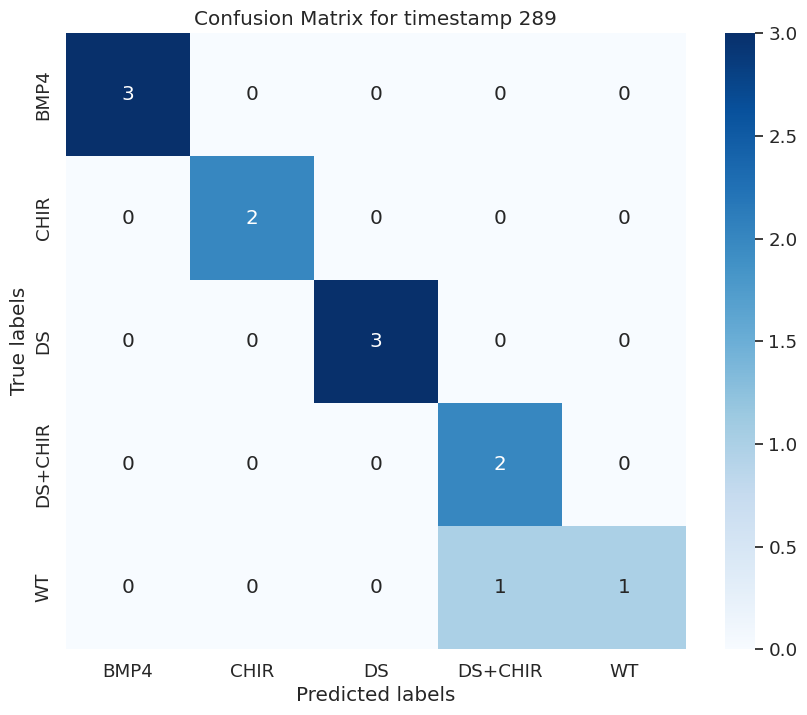

In [7]:
# for model in 
# accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns = train_net("googlenet")
model_names = [
    "resnet50",
    "resnet18", 
    "alexnet", 
    "vgg16",
    "densenet", 
    "inception", 
    "googlenet", 
    "resnext50_32x4d", 
    "wide_resnet50_2"
]
acc_map = {}
pre_map = {}
rec_map = {}
f1_map = {}
tps_map = {}
tns_map = {}
fps_map = {}
fns_map = {}
mis_total_map = {}
for model_name in model_names:
    print(f"training {model_name}...")
    current_date = datetime.now().strftime('%Y-%m-%d')
    os.makedirs(f"./output/tl/{current_date}/{model_name}", exist_ok=True)
    show_ = False
    accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list = train_net(model_name)
    plot_metric(accuracy_list, 'Accuracy', model=model_name, save=True, show=show_, output=f"output/tl/{current_date}", num_epochs=num_epochs)
    plot_metric(precision_list, 'Precision', model=model_name, save=True, show=show_,output=f"output/tl/{current_date}", num_epochs=num_epochs)
    plot_metric(recall_list, 'Recall', model=model_name, save=True, show=show_,output=f"output/tl/{current_date}", num_epochs=num_epochs)
    plot_metric(f1_list, 'F1 Score', model=model_name, save=True, show=show_,output=f"output/tl/{current_date}", num_epochs=num_epochs)
    for time in [1, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 289]:
    # for time in [1]:
        plot_confusion_matrix(confusion_matrix_list, time, save=True, show=show_,output=f"./output/tl/{current_date}/{model_name}")
    # acc_map[model_name] = accuracy_list
    # pre_map[model_name] = precision_list
    # rec_map[model_name] = recall_list
    # f1_map[model_name] = f1_list
    # tps_map[model_name] = tps
    # tns_map[model_name] = tns
    # fps_map[model_name] = fps
    # fns_map[model_name] = fns

    print(f"{model_name} average accuracy:", sum(accuracy_list) / len(accuracy_list))

    mis_map = write_result(model_name, accuracy_list, precision_list, recall_list, f1_list, tps, tns, fps, fns, confusion_matrix_list)
    if not mis_total_map:
        mis_total_map = mis_map
    else:
        mis_total_map  = add_dicts(mis_total_map, mis_map)
    # print(f"{model_name} misclassified map: {mis_map}")
    print(f"total map: {mis_total_map}")

In [15]:
accuracy_list =[1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.75, 0.8333333333333334, 0.8333333333333334, 0.6666666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 0.6666666666666666, 0.5833333333333334, 0.6666666666666666, 0.6666666666666666, 0.75, 1.0, 0.9166666666666666, 0.75, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.75, 0.8333333333333334, 0.75, 0.6666666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.75, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.75, 0.6666666666666666, 0.75, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.75, 0.75, 0.6666666666666666, 0.75, 0.8333333333333334, 0.75, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.75, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.75, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.75, 0.8333333333333334, 0.9166666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 0.8333333333333334, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 1.0, 0.8333333333333334, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 0.75, 0.75, 0.9166666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.8333333333333334, 1.0, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 1.0, 0.75, 0.9166666666666666, 0.75, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.8333333333333334, 1.0, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 1.0, 1.0]


In [16]:
precision_list =[1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 0.95, 0.9333333333333332, 1.0, 1.0, 0.8666666666666666, 0.8666666666666666, 0.8666666666666666, 0.85, 0.8333333333333333, 0.8666666666666666, 0.8666666666666666, 0.7, 0.8833333333333334, 0.9333333333333332, 0.8833333333333332, 0.8833333333333334, 0.8833333333333334, 0.9, 0.8333333333333333, 0.9333333333333332, 0.8, 0.85, 0.6833333333333333, 0.5533333333333333, 0.67, 0.62, 0.75, 1.0, 0.9333333333333332, 0.75, 0.95, 0.8666666666666666, 0.95, 0.9333333333333333, 0.8800000000000001, 0.9, 0.8333333333333333, 0.75, 0.9199999999999999, 0.95, 0.8666666666666666, 0.8333333333333334, 0.7333333333333333, 0.8666666666666666, 0.8666666666666666, 0.9333333333333333, 0.85, 0.85, 0.75, 0.85, 0.85, 0.7666666666666666, 0.6333333333333333, 0.7666666666666666, 0.85, 0.8666666666666666, 0.9333333333333333, 0.85, 0.7833333333333333, 0.7833333333333333, 0.6533333333333333, 0.6533333333333333, 0.85, 0.8166666666666667, 0.9333333333333332, 0.95, 0.95, 0.9, 0.95, 0.7833333333333333, 0.8666666666666666, 0.95, 0.8833333333333332, 0.8333333333333333, 0.8666666666666666, 0.9, 0.9333333333333332, 0.9, 0.9333333333333332, 0.95, 0.72, 0.95, 0.95, 0.9333333333333332, 0.8333333333333333, 0.9333333333333332, 0.9, 0.95, 0.8666666666666666, 0.9333333333333332, 0.72, 0.72, 0.6333333333333333, 0.6333333333333333, 0.8833333333333332, 0.72, 0.8666666666666666, 0.72, 0.9333333333333332, 1.0, 0.95, 0.9333333333333332, 0.95, 0.95, 0.8666666666666666, 0.8666666666666666, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 1.0, 0.9333333333333332, 0.95, 0.95, 0.72, 1.0, 1.0, 0.95, 0.95, 0.95, 0.95, 0.95, 0.8666666666666666, 0.6333333333333333, 0.72, 0.95, 1.0, 0.95, 1.0, 1.0, 0.95, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.95, 1.0, 1.0, 1.0, 0.9333333333333332, 0.95, 0.95, 0.8666666666666666, 1.0, 1.0, 0.9333333333333332, 0.9333333333333332, 1.0, 1.0, 1.0, 0.9, 0.95, 1.0, 0.9333333333333332, 0.9333333333333332, 0.8666666666666666, 0.95, 0.8666666666666666, 0.95, 0.95, 0.95, 0.95, 0.95, 0.8666666666666666, 0.8666666666666666, 0.8666666666666666, 0.9333333333333332, 0.9333333333333332, 0.9, 0.8666666666666666, 0.8666666666666666, 0.9333333333333332, 0.95, 0.8666666666666666, 0.5666666666666667, 0.8666666666666666, 0.8666666666666666, 0.8666666666666666, 0.9333333333333332, 0.8666666666666666, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 0.9333333333333332, 0.95, 1.0, 0.9333333333333332, 1.0, 0.8333333333333333, 1.0, 0.8333333333333333, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.95, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 0.8666666666666666, 0.9333333333333332, 0.9333333333333332, 1.0, 0.8666666666666666, 0.9333333333333332, 0.8666666666666666, 0.8666666666666666, 0.9, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.95, 0.9, 0.9333333333333332, 1.0, 1.0, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 1.0, 0.9333333333333332, 0.8833333333333332, 0.85, 0.8, 0.95, 1.0, 0.9333333333333332, 1.0, 1.0, 0.8666666666666666, 1.0, 0.9333333333333332, 0.9, 0.9, 1.0, 0.6166666666666666, 0.95, 0.6333333333333333, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 1.0, 1.0, 1.0, 0.95, 1.0, 0.9, 0.95, 1.0, 0.95, 1.0, 1.0, 0.8833333333333332, 1.0, 0.9333333333333332, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 0.95, 1.0, 0.95, 0.6833333333333333, 1.0, 1.0]

In [17]:
recall_list = [1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9333333333333332, 1.0, 1.0, 0.8333333333333333, 0.8333333333333333, 0.8666666666666666, 0.8333333333333333, 0.7666666666666666, 0.8333333333333333, 0.8333333333333333, 0.6666666666666666, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 0.8, 0.8333333333333333, 0.8666666666666666, 0.8333333333333333, 0.9, 0.7, 0.8333333333333333, 0.6333333333333333, 0.5333333333333333, 0.6, 0.6333333333333333, 0.7333333333333333, 1.0, 0.9333333333333332, 0.7333333333333333, 0.9, 0.8333333333333333, 0.9, 0.9, 0.7666666666666666, 0.8333333333333333, 0.7333333333333333, 0.6333333333333333, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 0.7666666666666666, 0.6666666666666666, 0.8333333333333333, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 0.8333333333333333, 0.6333333333333333, 0.8333333333333333, 0.8333333333333333, 0.7666666666666666, 0.6666666666666666, 0.7666666666666666, 0.8333333333333333, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 0.7333333333333333, 0.7333333333333333, 0.6333333333333333, 0.7, 0.8333333333333333, 0.7333333333333333, 0.9, 0.9, 0.9, 0.8, 0.9, 0.7333333333333333, 0.8333333333333333, 0.9, 0.8, 0.8333333333333333, 0.8333333333333333, 0.8, 0.9, 0.8333333333333333, 0.9333333333333332, 0.9, 0.8, 0.9, 0.9, 0.9, 0.7333333333333333, 0.9, 0.8, 0.9, 0.8333333333333333, 0.9, 0.8, 0.8, 0.7333333333333333, 0.7333333333333333, 0.8, 0.8, 0.8333333333333333, 0.8, 0.9333333333333332, 1.0, 0.9, 0.9333333333333332, 0.9, 0.9, 0.8333333333333333, 0.8333333333333333, 1.0, 1.0, 0.9, 0.9, 1.0, 1.0, 1.0, 0.9333333333333332, 0.9, 0.9, 0.8, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8333333333333333, 0.7333333333333333, 0.8, 0.9, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 0.9, 1.0, 1.0, 1.0, 0.9333333333333332, 0.9, 0.9, 0.8333333333333333, 1.0, 1.0, 0.9333333333333332, 0.9333333333333332, 1.0, 1.0, 1.0, 0.8666666666666666, 0.9, 1.0, 0.9333333333333332, 0.9333333333333332, 0.8333333333333333, 0.9, 0.8333333333333333, 0.9, 0.9, 0.9, 0.9, 0.9, 0.8333333333333333, 0.8333333333333333, 0.8333333333333333, 0.9333333333333332, 0.9333333333333332, 0.8666666666666666, 0.8333333333333333, 0.8333333333333333, 0.9333333333333332, 0.9, 0.8333333333333333, 0.6666666666666666, 0.8333333333333333, 0.8333333333333333, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 0.9333333333333332, 0.9, 1.0, 0.9333333333333332, 1.0, 0.8333333333333333, 1.0, 0.8333333333333333, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.9, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 0.8333333333333333, 0.9333333333333332, 0.9333333333333332, 1.0, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 0.8333333333333333, 0.8666666666666666, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.9, 0.8666666666666666, 0.9333333333333332, 1.0, 1.0, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 1.0, 0.9333333333333332, 0.8333333333333333, 0.7666666666666666, 0.7333333333333333, 0.9, 1.0, 0.9333333333333332, 1.0, 1.0, 0.8333333333333333, 1.0, 0.9333333333333332, 0.8666666666666666, 0.8666666666666666, 1.0, 0.7333333333333333, 0.9, 0.7333333333333333, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 0.9333333333333332, 1.0, 1.0, 1.0, 0.9, 1.0, 0.8, 0.9, 1.0, 0.9, 1.0, 1.0, 0.8333333333333333, 1.0, 0.9333333333333332, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 1.0, 0.9, 0.8, 1.0, 1.0]

In [18]:
f1_list =  [1.0, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 0.9199999999999999, 1.0, 1.0, 0.8266666666666665, 0.8266666666666665, 0.8400000000000001, 0.8314285714285713, 0.76, 0.8266666666666665, 0.8266666666666665, 0.6599999999999999, 0.8247619047619047, 0.9199999999999999, 0.8247619047619048, 0.7980952380952381, 0.8247619047619047, 0.8533333333333333, 0.8333333333333333, 0.8933333333333333, 0.7095238095238094, 0.8314285714285715, 0.638095238095238, 0.5166666666666666, 0.588095238095238, 0.61, 0.7314285714285715, 1.0, 0.9199999999999999, 0.7314285714285715, 0.9047619047619048, 0.8266666666666668, 0.9047619047619048, 0.8933333333333333, 0.7676190476190476, 0.8266666666666668, 0.7333333333333332, 0.6514285714285714, 0.8433333333333334, 0.9314285714285715, 0.8133333333333332, 0.7466666666666667, 0.6799999999999999, 0.8266666666666665, 0.8266666666666665, 0.9199999999999999, 0.8314285714285715, 0.8314285714285715, 0.6514285714285714, 0.8314285714285715, 0.8314285714285715, 0.7533333333333333, 0.6342857142857143, 0.7533333333333333, 0.8314285714285715, 0.8266666666666668, 0.9199999999999999, 0.8314285714285715, 0.738095238095238, 0.738095238095238, 0.6033333333333333, 0.6433333333333333, 0.8314285714285715, 0.7314285714285714, 0.8933333333333333, 0.9047619047619048, 0.9047619047619048, 0.8095238095238095, 0.9047619047619048, 0.738095238095238, 0.8266666666666668, 0.9047619047619048, 0.798095238095238, 0.82, 0.8266666666666668, 0.8095238095238095, 0.8933333333333333, 0.8266666666666668, 0.9199999999999999, 0.9047619047619048, 0.75, 0.9047619047619048, 0.9047619047619048, 0.8933333333333333, 0.7333333333333332, 0.8933333333333333, 0.7999999999999999, 0.9047619047619048, 0.8266666666666668, 0.8933333333333333, 0.75, 0.75, 0.6666666666666666, 0.6742857142857143, 0.798095238095238, 0.75, 0.8266666666666668, 0.75, 0.9199999999999999, 1.0, 0.9047619047619048, 0.9199999999999999, 0.9047619047619048, 0.9047619047619048, 0.8266666666666668, 0.8266666666666668, 1.0, 1.0, 0.9047619047619048, 0.9047619047619048, 1.0, 1.0, 1.0, 0.9199999999999999, 0.9047619047619048, 0.9047619047619048, 0.75, 1.0, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.8266666666666668, 0.6742857142857143, 0.75, 0.9047619047619048, 1.0, 0.9047619047619048, 1.0, 1.0, 0.9047619047619048, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 1.0, 0.9047619047619048, 1.0, 1.0, 1.0, 0.9199999999999999, 0.9047619047619048, 0.9047619047619048, 0.8266666666666668, 1.0, 1.0, 0.9199999999999999, 0.9199999999999999, 1.0, 1.0, 1.0, 0.8333333333333333, 0.9047619047619048, 1.0, 0.9199999999999999, 0.9199999999999999, 0.8266666666666668, 0.9047619047619048, 0.8266666666666668, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.8266666666666668, 0.8266666666666668, 0.8266666666666668, 0.9199999999999999, 0.9199999999999999, 0.8333333333333333, 0.8266666666666668, 0.8266666666666668, 0.9199999999999999, 0.9047619047619048, 0.8266666666666668, 0.6, 0.8266666666666668, 0.8266666666666668, 0.8266666666666668, 0.9199999999999999, 0.8266666666666668, 1.0, 1.0, 1.0, 0.9199999999999999, 1.0, 0.9199999999999999, 0.9047619047619048, 1.0, 0.9199999999999999, 1.0, 0.8333333333333333, 1.0, 0.8333333333333333, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 0.9047619047619048, 1.0, 1.0, 1.0, 0.9199999999999999, 1.0, 0.8266666666666668, 0.9199999999999999, 0.9199999999999999, 1.0, 0.8266666666666668, 0.9199999999999999, 0.8266666666666668, 0.8266666666666668, 0.8333333333333333, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 0.9047619047619048, 0.8333333333333333, 0.9199999999999999, 1.0, 1.0, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 1.0, 0.9199999999999999, 0.8247619047619048, 0.738095238095238, 0.7476190476190476, 0.9047619047619048, 1.0, 0.9199999999999999, 1.0, 1.0, 0.8266666666666668, 1.0, 0.9199999999999999, 0.8333333333333333, 0.8333333333333333, 1.0, 0.6647619047619048, 0.9047619047619048, 0.6742857142857143, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 0.9199999999999999, 1.0, 1.0, 1.0, 0.9047619047619048, 1.0, 0.8095238095238095, 0.9047619047619048, 1.0, 0.9047619047619048, 1.0, 1.0, 0.8247619047619048, 1.0, 0.9199999999999999, 1.0, 1.0, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8933333333333333, 0.9047619047619048, 1.0, 0.9047619047619048, 0.7314285714285715, 1.0, 1.0]

In [8]:
accuracy_list =[0.6666666666666666, 0.75, 0.6666666666666666, 0.8333333333333334, 0.9166666666666666, 0.75, 1.0, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.6666666666666666, 0.75, 0.5833333333333334, 0.6666666666666666, 0.75, 0.75, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 0.6666666666666666, 0.4166666666666667, 0.6666666666666666, 0.75, 0.75, 0.75, 0.75, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 0.75, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.75, 0.75, 0.9166666666666666, 1.0, 0.9166666666666666, 0.75, 0.8333333333333334, 0.6666666666666666, 0.9166666666666666, 0.9166666666666666, 0.6666666666666666, 0.75, 0.6666666666666666, 0.9166666666666666, 0.6666666666666666, 0.75, 0.6666666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 0.75, 0.6666666666666666, 0.75, 0.75, 0.75, 0.8333333333333334, 0.8333333333333334, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 1.0, 0.9166666666666666, 1.0, 0.8333333333333334, 0.75, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.75, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.75, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 0.75, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.75, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.75, 0.8333333333333334, 1.0, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 0.75, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.75, 0.75, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.5833333333333334, 1.0, 0.8333333333333334, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.8333333333333334, 1.0, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 0.9166666666666666, 0.8333333333333334, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 0.8333333333333334, 0.75, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.8333333333333334, 1.0, 0.75, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 1.0, 0.9166666666666666, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 1.0, 1.0, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 1.0, 0.8333333333333334, 0.9166666666666666, 1.0, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0, 0.9166666666666666, 0.9166666666666666]
precision_list =  [0.7666666666666666, 0.7666666666666666, 0.5333333333333333, 0.8833333333333332, 0.9333333333333333, 0.8333333333333333, 1.0, 0.95, 0.9333333333333333, 0.8333333333333333, 0.9199999999999999, 0.72, 0.8333333333333333, 0.5333333333333333, 0.67, 0.45, 0.5666666666666667, 0.7, 0.8, 0.9333333333333332, 0.8833333333333332, 0.95, 0.72, 0.9333333333333332, 0.6533333333333333, 0.8833333333333332, 0.6799999999999999, 0.35, 0.65, 0.8, 0.82, 0.7833333333333333, 0.72, 0.8333333333333333, 0.8666666666666666, 0.95, 0.95, 0.9333333333333332, 0.95, 1.0, 0.85, 0.9333333333333332, 0.62, 0.82, 0.9199999999999999, 0.8833333333333332, 0.8833333333333332, 0.62, 0.82, 0.95, 1.0, 0.95, 0.6533333333333333, 0.9199999999999999, 0.67, 0.95, 0.9333333333333333, 0.5833333333333333, 0.7, 0.72, 0.95, 0.5866666666666667, 0.9, 0.7, 0.72, 0.8833333333333332, 0.95, 0.7, 0.9199999999999999, 0.7, 0.48571428571428577, 0.7, 0.8533333333333333, 0.82, 0.72, 0.72, 0.6533333333333333, 0.8833333333333332, 0.9199999999999999, 0.72, 0.9, 1.0, 0.95, 1.0, 0.85, 0.8, 0.72, 0.85, 0.85, 0.7666666666666666, 0.85, 0.72, 0.95, 0.72, 0.8, 0.72, 0.8833333333333332, 0.95, 0.8666666666666666, 0.8666666666666666, 0.8666666666666666, 0.72, 0.6333333333333333, 0.72, 0.95, 0.72, 0.72, 0.95, 0.95, 0.95, 1.0, 0.95, 0.72, 0.95, 0.95, 1.0, 0.7, 0.95, 0.9333333333333333, 0.7, 0.95, 0.7666666666666666, 0.72, 0.95, 0.72, 0.95, 1.0, 0.85, 0.9333333333333332, 0.72, 0.95, 0.72, 0.6533333333333333, 0.95, 1.0, 0.72, 0.95, 0.95, 0.95, 0.72, 0.95, 0.6333333333333333, 0.72, 1.0, 1.0, 0.8666666666666666, 0.95, 0.95, 1.0, 1.0, 0.95, 0.7, 0.95, 1.0, 0.95, 0.8666666666666666, 0.9333333333333332, 0.8666666666666666, 0.95, 0.95, 0.95, 0.8, 0.6333333333333333, 0.95, 1.0, 0.95, 0.95, 0.95, 0.63, 1.0, 0.8666666666666666, 0.95, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 0.95, 0.95, 0.95, 1.0, 0.95, 0.95, 1.0, 0.95, 1.0, 1.0, 0.9333333333333332, 0.9333333333333332, 1.0, 0.95, 0.8666666666666666, 1.0, 0.95, 1.0, 1.0, 0.95, 1.0, 1.0, 1.0, 0.95, 0.9199999999999999, 0.9333333333333332, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 0.95, 1.0, 0.95, 0.95, 1.0, 1.0, 0.85, 0.7, 0.72, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 0.9333333333333332, 1.0, 0.8666666666666666, 1.0, 0.6333333333333333, 1.0, 0.95, 0.95, 0.95, 0.95, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0, 1.0, 0.95, 0.95, 0.95, 1.0, 1.0, 0.95, 0.8666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 1.0, 1.0, 0.95, 0.95, 0.95, 1.0, 0.9, 0.95, 1.0, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 0.95, 0.95, 1.0, 0.95, 0.95, 1.0, 0.9333333333333332, 0.9333333333333332]
recall_list = [0.7, 0.7666666666666666, 0.6333333333333333, 0.8333333333333333, 0.9, 0.7666666666666666, 1.0, 0.9, 0.9, 0.8333333333333333, 0.8, 0.8, 0.8333333333333333, 0.6333333333333333, 0.7, 0.5333333333333333, 0.6333333333333333, 0.7, 0.7333333333333333, 0.9333333333333332, 0.8333333333333333, 0.9, 0.8, 0.9333333333333332, 0.7333333333333333, 0.8, 0.6333333333333333, 0.36666666666666664, 0.6333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333, 0.7, 0.8333333333333333, 0.8333333333333333, 0.9, 0.9, 0.9333333333333332, 0.9, 1.0, 0.8, 0.9333333333333332, 0.7, 0.7333333333333333, 0.8, 0.8333333333333333, 0.8, 0.7, 0.7333333333333333, 0.9, 1.0, 0.9, 0.7, 0.8, 0.6, 0.9, 0.9, 0.6333333333333333, 0.7, 0.6333333333333333, 0.9, 0.6, 0.7333333333333333, 0.6333333333333333, 0.7, 0.8, 0.9, 0.7, 0.8333333333333333, 0.7, 0.6, 0.7, 0.7333333333333333, 0.7, 0.8, 0.8, 0.7, 0.8, 0.8, 0.8, 0.8, 1.0, 0.9, 1.0, 0.8333333333333333, 0.7333333333333333, 0.8, 0.8, 0.8333333333333333, 0.7333333333333333, 0.8, 0.8, 0.9, 0.8, 0.7333333333333333, 0.8, 0.8, 0.9, 0.8333333333333333, 0.8333333333333333, 0.8333333333333333, 0.8, 0.7333333333333333, 0.8, 0.9, 0.8, 0.8, 0.9, 0.9, 0.9, 1.0, 0.9, 0.8, 0.9, 0.9, 1.0, 0.8, 0.9, 0.9, 0.8, 0.9, 0.7333333333333333, 0.8, 0.9, 0.8, 0.9, 1.0, 0.8, 0.9333333333333332, 0.8, 0.9, 0.8, 0.7, 0.9, 1.0, 0.8, 0.9, 0.9, 0.9, 0.8, 0.9, 0.7333333333333333, 0.8, 1.0, 1.0, 0.8333333333333333, 0.9, 0.9, 1.0, 1.0, 0.9, 0.7, 0.9, 1.0, 0.9, 0.8333333333333333, 0.9333333333333332, 0.8333333333333333, 0.9, 0.9, 0.9, 0.7666666666666666, 0.7333333333333333, 0.9, 1.0, 0.9, 0.9, 0.9, 0.6, 1.0, 0.8333333333333333, 0.9, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 0.9, 0.9, 0.9, 1.0, 0.9, 0.9, 1.0, 0.9, 1.0, 1.0, 0.9333333333333332, 0.9333333333333332, 1.0, 0.9, 0.8333333333333333, 1.0, 0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 1.0, 0.9, 0.8, 0.9333333333333332, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 0.9, 1.0, 0.9, 0.9, 1.0, 1.0, 0.8, 0.7, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 0.9333333333333332, 1.0, 0.8333333333333333, 1.0, 0.7333333333333333, 1.0, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 0.9, 1.0, 1.0, 0.9, 0.9, 0.9, 1.0, 1.0, 0.9, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 1.0, 1.0, 0.9, 0.9, 0.9, 1.0, 0.8666666666666666, 0.9, 1.0, 0.8666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9333333333333332, 1.0, 0.9, 0.9, 1.0, 0.9, 0.9, 1.0, 0.9333333333333332, 0.9333333333333332]
f1_list = [0.6733333333333333, 0.72, 0.5733333333333334, 0.8247619047619048, 0.8933333333333333, 0.7676190476190476, 1.0, 0.9047619047619048, 0.8933333333333333, 0.8333333333333333, 0.8166666666666667, 0.75, 0.8333333333333333, 0.5742857142857144, 0.6547619047619048, 0.48571428571428577, 0.5942857142857143, 0.6666666666666666, 0.7476190476190476, 0.9199999999999999, 0.8247619047619048, 0.9047619047619048, 0.75, 0.9199999999999999, 0.6699999999999999, 0.798095238095238, 0.6333333333333333, 0.35714285714285715, 0.6190476190476191, 0.7476190476190476, 0.7433333333333334, 0.7247619047619047, 0.6833333333333333, 0.8333333333333333, 0.8266666666666668, 0.9047619047619048, 0.9047619047619048, 0.9199999999999999, 0.9047619047619048, 1.0, 0.8047619047619048, 0.9199999999999999, 0.65, 0.7433333333333334, 0.8166666666666667, 0.8247619047619047, 0.798095238095238, 0.65, 0.7433333333333334, 0.9047619047619048, 1.0, 0.9047619047619048, 0.6433333333333333, 0.8166666666666667, 0.588095238095238, 0.9047619047619048, 0.8933333333333333, 0.5790476190476191, 0.6666666666666666, 0.6433333333333333, 0.9047619047619048, 0.5633333333333332, 0.76, 0.6266666666666667, 0.6833333333333333, 0.798095238095238, 0.9047619047619048, 0.6666666666666666, 0.8433333333333334, 0.6666666666666666, 0.52, 0.6666666666666666, 0.7366666666666666, 0.7166666666666666, 0.75, 0.75, 0.6433333333333333, 0.798095238095238, 0.8166666666666667, 0.75, 0.8095238095238095, 1.0, 0.9047619047619048, 1.0, 0.8314285714285715, 0.7476190476190476, 0.75, 0.8047619047619048, 0.8314285714285715, 0.7266666666666667, 0.8047619047619048, 0.75, 0.9047619047619048, 0.75, 0.7476190476190476, 0.75, 0.798095238095238, 0.9047619047619048, 0.8266666666666668, 0.8266666666666668, 0.8266666666666668, 0.75, 0.6742857142857143, 0.75, 0.9047619047619048, 0.75, 0.75, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 1.0, 0.9047619047619048, 0.75, 0.9047619047619048, 0.9047619047619048, 1.0, 0.7428571428571429, 0.9047619047619048, 0.8933333333333333, 0.7428571428571429, 0.9047619047619048, 0.7266666666666667, 0.75, 0.9047619047619048, 0.75, 0.9047619047619048, 1.0, 0.8047619047619048, 0.9199999999999999, 0.75, 0.9047619047619048, 0.75, 0.6433333333333333, 0.9047619047619048, 1.0, 0.75, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.75, 0.9047619047619048, 0.6742857142857143, 0.75, 1.0, 1.0, 0.8266666666666668, 0.9047619047619048, 0.9047619047619048, 1.0, 1.0, 0.9047619047619048, 0.6666666666666666, 0.9047619047619048, 1.0, 0.9047619047619048, 0.8266666666666668, 0.9199999999999999, 0.8266666666666668, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.7466666666666666, 0.6742857142857143, 0.9047619047619048, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.5523809523809524, 1.0, 0.8266666666666668, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 1.0, 0.9047619047619048, 0.9047619047619048, 1.0, 0.9047619047619048, 1.0, 1.0, 0.9199999999999999, 0.9199999999999999, 1.0, 0.9047619047619048, 0.8266666666666668, 1.0, 0.9047619047619048, 1.0, 1.0, 0.9047619047619048, 1.0, 1.0, 1.0, 0.9047619047619048, 0.8166666666666667, 0.9199999999999999, 1.0, 1.0, 1.0, 1.0, 0.9199999999999999, 0.9047619047619048, 1.0, 0.9047619047619048, 0.9047619047619048, 1.0, 1.0, 0.8047619047619048, 0.6666666666666666, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.9199999999999999, 1.0, 0.8266666666666668, 1.0, 0.6742857142857143, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 1.0, 1.0, 1.0, 1.0, 0.9047619047619048, 1.0, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 1.0, 1.0, 0.9047619047619048, 0.8266666666666668, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9199999999999999, 1.0, 1.0, 1.0, 0.9047619047619048, 0.9047619047619048, 0.9047619047619048, 1.0, 0.8333333333333333, 0.9047619047619048, 1.0, 0.8333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9199999999999999, 1.0, 0.9047619047619048, 0.9047619047619048, 1.0, 0.9047619047619048, 0.9047619047619048, 1.0, 0.9199999999999999, 0.9199999999999999]

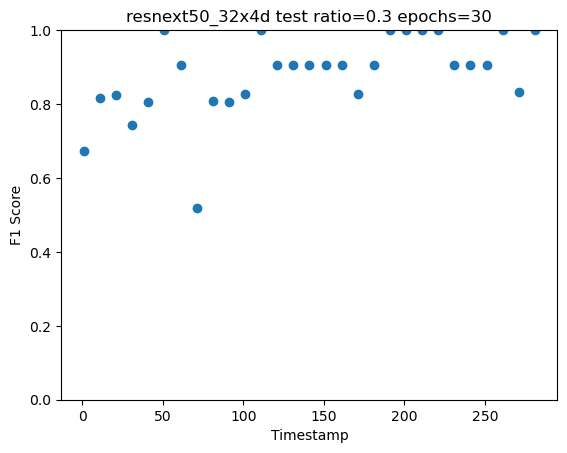

In [9]:
plot_metric(accuracy_list, 'Accuracy', model="resnext50_32x4d", save=True, show=show_, output=f"output/tl/2024-02-24", num_epochs=num_epochs, test_ratio=0.3)
plot_metric(precision_list, 'Precision', model="resnext50_32x4d", save=True, show=show_,output=f"output/tl/2024-02-24", num_epochs=num_epochs, test_ratio=0.3)
plot_metric(recall_list, 'Recall', model="resnext50_32x4d", save=True, show=show_,output=f"output/tl/2024-02-24", num_epochs=num_epochs, test_ratio=0.3)
plot_metric(f1_list, 'F1 Score', model="resnext50_32x4d", save=True, show=show_,output=f"output/tl/2024-02-24", num_epochs=num_epochs, test_ratio=0.3)

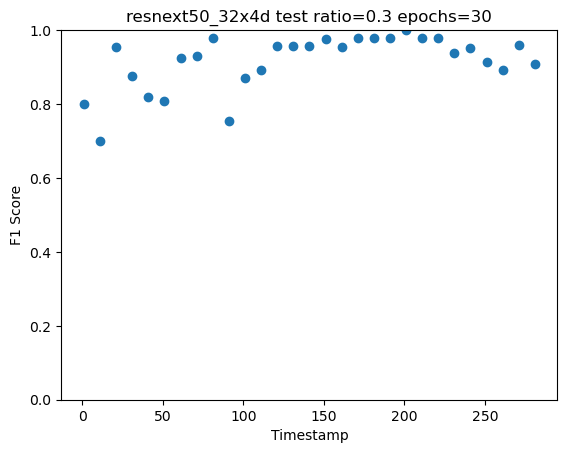

In [6]:
show_ = False
num_epochs = 30
plot_metric(accuracy_list, 'Accuracy', model="resnext50_32x4d", save=True, show=show_, output=f"output/tl+rotation/2024-02-25", num_epochs=num_epochs, test_ratio=0.3)
plot_metric(precision_list, 'Precision', model="resnext50_32x4d", save=True, show=show_,output=f"output/tl+rotation/2024-02-25", num_epochs=num_epochs, test_ratio=0.3)
plot_metric(recall_list, 'Recall', model="resnext50_32x4d", save=True, show=show_,output=f"output/tl+rotation/2024-02-25", num_epochs=num_epochs, test_ratio=0.3)
plot_metric(f1_list, 'F1 Score', model="resnext50_32x4d", save=True, show=show_,output=f"output/tl+rotation/2024-02-25", num_epochs=num_epochs, test_ratio=0.3)